# Bayesian Regression Examples

+ Using sklean and synthetic data


## Bayesian Ridge Regression

### Packages

In [1]:
%matplotlib inline
# data and plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modeling packages
import scipy.stats as stats
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression

### Display Settings

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

### Data Generation
We create synthetic data "by hand".  
The dataset contains n_samples observations and n_features regressors.  

The same operations can be done by using the sklearn.datasets.make_regression function.

In [2]:
np.random.seed(0)     # fix the seed for reproducibily

n_samples = 100
n_features = 100       # total features from which we randomly select a subset of n_relfeat
n_relfeat = 10         # number of relevant features, i.e. with non-zero weights

# precision for weights
lmbda = 4.            # 1/lmbda is the variance of the normal from which we generate weights
# volatility of noise
sigma = 0.10          #  sigma^2 is the variance of the normal from which we generate noise

X = np.random.randn(n_samples, n_features)                       # standard normal deviates
relfeat_idx = np.random.randint(0, n_features, n_relfeat)

# create weights for each feature
# initially all weights are set to zero 
w = np.zeros(n_features)
# for the relevant features the weights are samples from the normal distribution with zero mean and variance = 1/lmbda
for i in relfeat_idx:
    w[i] = stats.norm.rvs(loc=0, scale=1.0 / np.sqrt(lmbda))
# create white noise by sampling  the normal distribution with zero mean and variance = sigma^2
noise = stats.norm.rvs(loc=0, scale=sigma, size=n_samples)
# create the output variable
y = X @ w + noise

### Model Fits
We fit a Bayesian Ridge and a standard OLS model

In [4]:
brg = BayesianRidge(compute_score=True)
brg.fit(X, y)

ols = LinearRegression()
ols.fit(X, y);

### Result Plots
First we plot the actual, Bayesian and OLS weights for each feature.

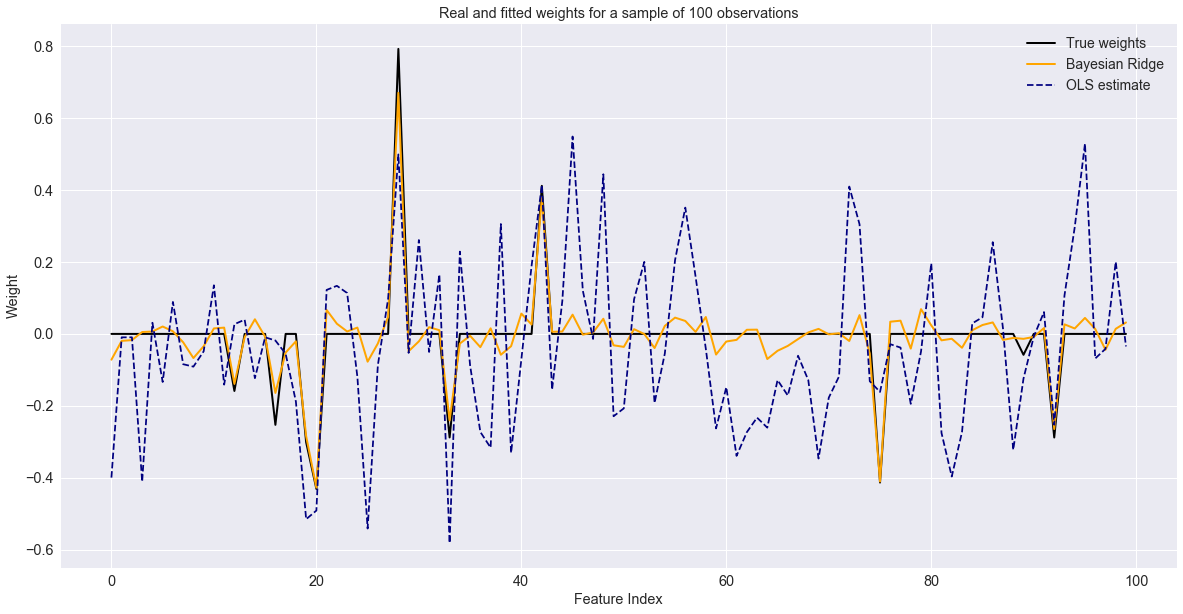

In [5]:
lw = 2
plt.figure()
plt.plot(w, color='black', linewidth=lw, label="True weights")
plt.plot(brg.coef_, color='orange', linewidth=lw, label="Bayesian Ridge")
plt.plot(ols.coef_, color='navy', linestyle='--', label="OLS estimate")
plt.xlabel("Feature Index")
plt.ylabel("Weight")
plt.title("Real and fitted weights for a sample of {} observations".format(n_samples))
plt.legend(loc="best", prop=dict(size=14));

Then we plot the log likehood after each iteration, to see how the Bayesian model converges

Log-liq:  [457.14 686.48 695.01 699.5  701.78 702.91 703.46 703.74 703.87 703.93
 703.97]


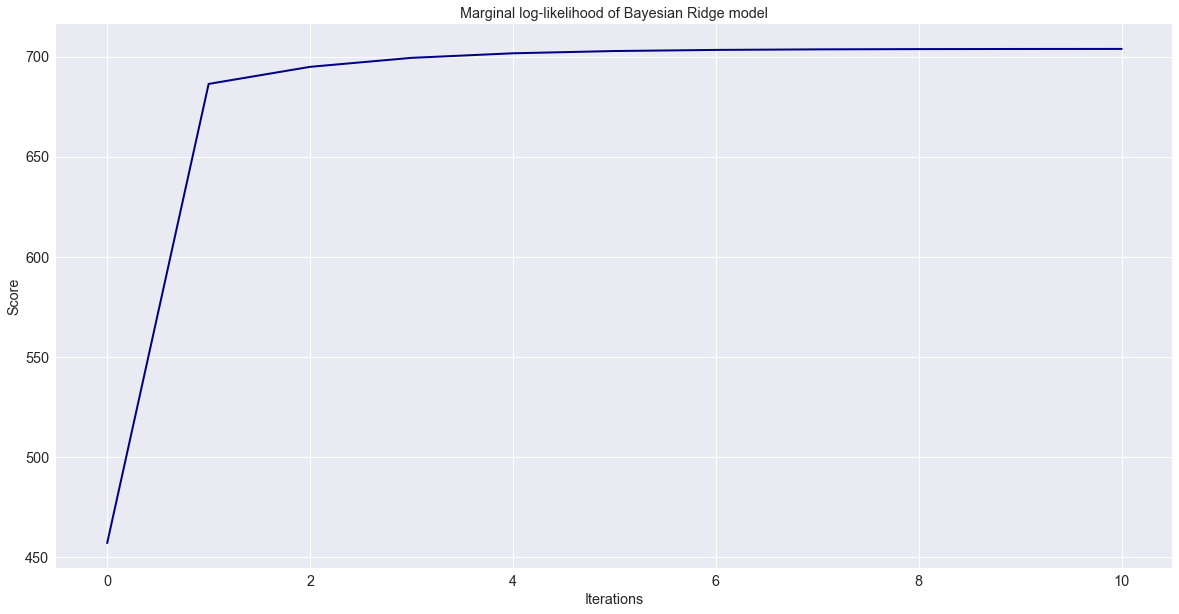

In [6]:
plt.figure()
plt.plot(brg.scores_, color='navy', linewidth=lw)
plt.ylabel("Score")
plt.xlabel("Iterations")
plt.title("Marginal log-likelihood of Bayesian Ridge model")

print("Log-liq: ", np.round(brg.scores_, 2))

## Bayesian Polynomial Regression 

The output is $y(x) = \sqrt{x} \sin(x) + \sigma \epsilon$, with $\epsilon$ being standard normal noise.  
The volatility parameter $\sigma$ controls the amount of noise.  
The features are all polynomials of $x$ up to a set degree.  
We create a design matrix $\Phi$ containing the polynomials (Vandermonde matrix).  
We use Bayesian Ridge regression to fit the output.  
We plot fitted values and error bars against observations.

### Data Generation and Model Fit

In [7]:
degree = 4         # the polynomial degree

# small helper function to create a sin curve with noise
# returns sqrt(x) * sin(x) + sigma * epsilon
def f(x, sigma):
    y = np.sqrt(x) * np.sin(x)
    noise = np.random.normal(0, 1, len(x))
    return y + sigma * noise

# create the data and fit the model
XX = np.linspace(0, 10, 100)
# create the Vandermonde matrix
Phi = np.vander(XX, degree + 1, increasing=True)
yy = f(XX, sigma=0.10)
# fit a Bayesian model
brg_poly = BayesianRidge()
brg_poly.fit(Phi, yy)

# display the top of the Vandermonte matrix
pd.DataFrame(data=Phi).head()

,0,1,2,3,4
0,1.0,0.00000,0.000000,0.000000,0.000000
1,1.0,0.10101,0.010203,0.001031,0.000104
2,1.0,0.20202,0.040812,0.008245,0.001666
3,1.0,0.30303,0.091827,0.027826,0.008432
4,1.0,0.40404,0.163249,0.065959,0.026650


### Result Plots

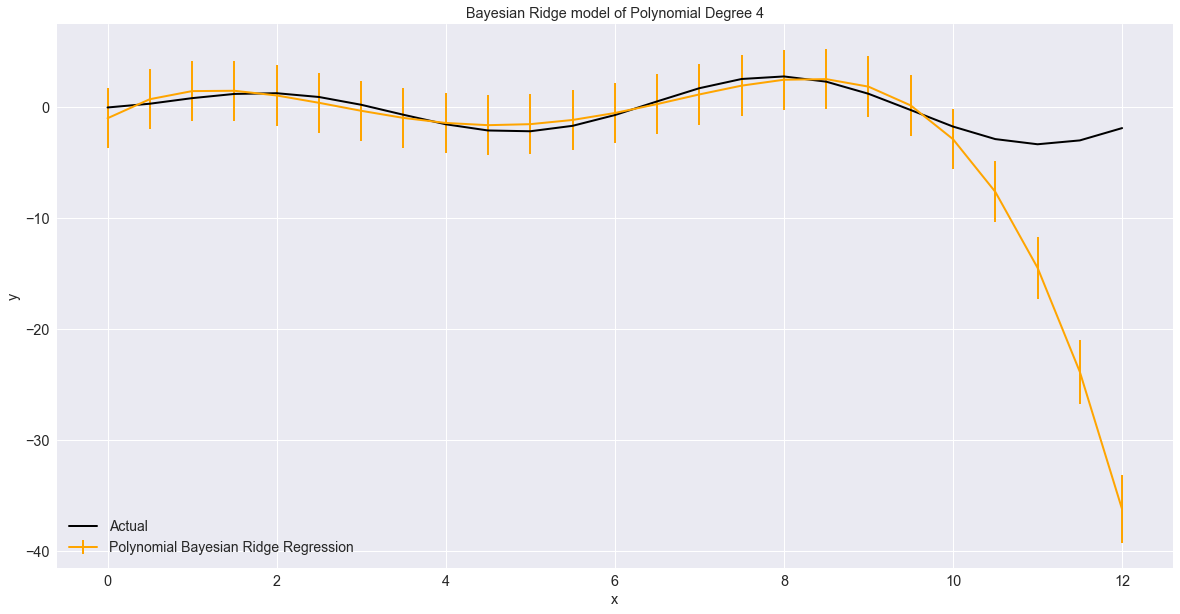

In [8]:
# plot fitted and actual values
X_plot = np.linspace(0, 12, 25)
y_plot = f(X_plot, sigma=0)
# NOTE: the input features must be transformed the same way as for fitting
Phi_plot = np.vander(X_plot, degree + 1, increasing=True)
# get the model predictions
y_mean, y_std = brg_poly.predict(Phi_plot, return_std=True)

plt.figure()
plt.errorbar(X_plot, y_mean, y_std, linewidth=lw,  color='orange', label="Polynomial Bayesian Ridge Regression")
plt.plot(X_plot, y_plot, color='black', linewidth=lw, label="Actual")
plt.ylabel("y")
plt.xlabel("x")
plt.title("Bayesian Ridge model of Polynomial Degree {}".format(degree))
plt.legend(loc="lower left", prop=dict(size=14));